# Bayesian Optimization with Integer Parameter and Constraint Bounds

This notebook demonstrates the use of Bayesian optimization to optimize the pion lucite detector design for the MOLLER experiment. It assumes Gaussian process noise, so it requires a simulation where we are well outside of Poisson statistics regime. It currently uses the bayesian-optimization and scikit-optimize modules, but presumably there are other options (MC-Stan).

### User Input

User input to this script, if you wish to adapt it, should be a simulation macro and an analysis macro that returns a target to optimize. 

In [1]:
# Working directory, assumes build/ will contain remoll and reroot
remoll   = '/home/wdconinc/git/remoll/'
# Geometry file to modify with parameters
geomfile = remoll + 'geometry/pion/Lucite/pionDetectorLucite.gdml'
# Simulation macro, all output to cerr, cout is ignored
macro    = remoll + 'macros/pion/pionDetectorLucite.mac'
# Analysis macro which produces a floating point number as last line
analysis = remoll + 'analysis/pion/pionDetectorLucite_pe.C("pionDetectorLucite_pi.root")'

## Parameter Boundaries

We introduce some boundaries on the parameter space. Some of these are practical, others are softer constraints. Integer values are written without floating point, real values are written with the floating point.

Later one, bayes_opt will allow for lower boundary == upper boundary constraints, but scikit-optimize requires some handholding.

In [3]:
# Bounded region of parameter space, with names of variables
# Note: Order here must correspond with what the target function expects!
bounds = {
    'N_P': (3, 3),  # integer
    'PlaneThickness': (1., 1.), # in
    'InsideWidth': (30., 30.),  # cm
    'OutsideWidth': (30., 30.), # cm
    'Height': (25., 25.), # cm
    'Theta': (-20., +20.), # deg
    'WedgeSide': (-1.0, +1.0), # fraction [-1,+1]
    'WedgeHeightFraction': (0.01, 2.0), # fraction ]0,inf[
    'WedgeBevelFraction': (0.01, 1.0), # fraction ]0,1[
    'ReflectorLightGuideHeight': (20., 20.), # cm
    'ReflectorHeightFraction': (0.1, 0.9), # ]0,1[
    'ReflectorWidth': (20., 40.), # cm
    'ReflectorDepth': (2*2.54, 4*2.54), # cm
    'ReflectorTheta': (-20., +20.), # deg
    'LightGuideTheta': (-20., +20.), # deg
    'PMTDiameter': (3, 3) # integer inches
}
# Note: Changes here require re-running the function definition below!

## Input Parameter Processing and Job Configuration

First we have to setup the way to get our parameters from inside this notebook to the simulation environment. We do this with a regex using the `re` module that modifies selected GDML parameters.

Next we have to provide a function that returns our target value (here, the number of photoelectrons reaching the photocathode of the detector). We use `subprocess` to run the processes outside of the python notebook and parse the output that is then cast back into a real value.

In [8]:
import subprocess
import fileinput
import math
import re

def set_geometry(file, name, value):
    """
    Modify the value of the gdml variable <name> to <value> in <file>.
    """
    #print("Setting %s to %s" % (name,value))
    for line in fileinput.input(file, inplace = True):
        print(re.sub(r'(name="%s"[^\>]*value)="[^"]*"' % name, r'\1="%s"' % str(value), line), end = '')
    fileinput.close()

def run_simulation( # Using avg = sum/2 to set correctly if bounds are identical
        N_P                 = sum(bounds['N_P'])/2,
        PlaneThickness      = sum(bounds['PlaneThickness'])/2,
        InsideWidth         = sum(bounds['InsideWidth'])/2,
        OutsideWidth        = sum(bounds['OutsideWidth'])/2,
        Height              = sum(bounds['Height'])/2,
        Theta               = sum(bounds['Theta'])/2,
        WedgeSide           = sum(bounds['WedgeSide'])/2,
        WedgeHeightFraction = sum(bounds['WedgeHeightFraction'])/2,
        WedgeBevelFraction  = sum(bounds['WedgeBevelFraction'])/2,
        ReflectorLightGuideHeight = sum(bounds['ReflectorLightGuideHeight'])/2,
        ReflectorHeightFraction   = sum(bounds['ReflectorHeightFraction'])/2,
        ReflectorWidth      = sum(bounds['ReflectorWidth'])/2,
        ReflectorDepth      = sum(bounds['ReflectorDepth'])/2,
        ReflectorTheta      = sum(bounds['ReflectorTheta'])/2,
        LightGuideTheta     = sum(bounds['LightGuideTheta'])/2,
        PMTDiameter         = sum(bounds['PMTDiameter'])/2):
    """
    Run a single simulation step with specified parameters.
    """

    # Require integer values for the following parameters
    N_P = int(N_P)
    PMTDiameter    = int(PMTDiameter)

    # Modify the geometry
    set_geometry(geomfile, "N_P", N_P)
    set_geometry(geomfile, "pionDetectorLucitePlaneThickness",      PlaneThickness * 2.54)
    set_geometry(geomfile, "pionDetectorLuciteInsideWidth",         InsideWidth)
    set_geometry(geomfile, "pionDetectorLuciteOutsideWidth",        OutsideWidth)
    set_geometry(geomfile, "pionDetectorLuciteHeight",              Height)
    set_geometry(geomfile, "pionDetectorLuciteTheta",               Theta)
    set_geometry(geomfile, "pionDetectorLuciteWedgeSide",           WedgeSide)
    set_geometry(geomfile, "pionDetectorLuciteWedgeHeightFraction", WedgeHeightFraction)
    set_geometry(geomfile, "pionDetectorLuciteWedgeBevelFraction",  WedgeBevelFraction)
    set_geometry(geomfile, "pionDetectorLuciteReflectorLightGuideHeight", ReflectorLightGuideHeight)
    set_geometry(geomfile, "pionDetectorLuciteReflectorHeightFraction", ReflectorHeightFraction)
    set_geometry(geomfile, "pionDetectorLuciteReflectorWidth",      ReflectorWidth)
    set_geometry(geomfile, "pionDetectorLuciteReflectorDepth",      ReflectorDepth)
    set_geometry(geomfile, "pionDetectorLuciteReflectorTheta",      ReflectorTheta)
    set_geometry(geomfile, "pionDetectorLuciteLightGuideTheta",     LightGuideTheta)
    set_geometry(geomfile, "pionDetectorLucitePMTDiameter",         PMTDiameter * 2.54)
    
    # Run simulation
    proc = subprocess.run(["build/remoll", "-t", "4", macro],
                   cwd = '/home/wdconinc/git/remoll',
                   stdout = subprocess.DEVNULL,
                   stderr = subprocess.DEVNULL,
                   encoding = 'utf-8')
    
    # Run analysis
    proc = subprocess.run(["build/reroot", "-l", "-q", analysis],
                   cwd = '/home/wdconinc/git/remoll',
                   stdout = subprocess.PIPE, 
                   stderr = subprocess.DEVNULL,
                   encoding = 'utf-8')

    # Collect output values: second to last line (last line empty), first word
    number_of_pes = float(proc.stdout.split('\n')[-2].split(' ')[0])
    
    # Detector area, thickness and volume
    area = 0.5 * (InsideWidth + OutsideWidth) * Height
    thickness = N_P * PlaneThickness / math.cos(math.radians(Theta))
    volume = thickness * area
    
    # Generated number of PEs, for lucite: N_gamma^inf = 412.0 photons / cm between 300 nm and 600 nm
    generated_number_of_photons = 412.0 * thickness

    # Normalize number of PEs to the number of PEs generated by the track
    return number_of_pes / generated_number_of_photons

## Bayesian Optimization with `bayes_opt`

We first install the package with pip, setup the optimizer, setup log file reading and writing for history between consecutive sessions, and then optimize.

In [ ]:
!pip install --user bayesian-optimization

from bayes_opt import BayesianOptimization
from bayes_opt.util import load_logs

# Setup Bayesian optimizer
optimizer = BayesianOptimization(
    f = run_simulation,
    pbounds = bounds,
    verbose = 2, # verbose = 1 prints only when a maximum is observed, verbose = 0 is silent
    random_state = 1,
)

# New optimizer is loaded with previously seen points
import os.path
logfile = "./logs.json"
if os.path.isfile(logfile):
    load_logs(optimizer, logs = [logfile]);
    
from bayes_opt.observer import JSONLogger
from bayes_opt.event import Events

logger = JSONLogger(path = logfile)
optimizer.subscribe(Events.OPTMIZATION_STEP, logger)

# Now start optimization from init_points exploration points and n_iter iterations
res = optimizer.maximize(
    init_points = 2,
    n_iter = 40,
)

## Bayesian Optimization with scikit-optimize (`skopt`)

To treat the zero-width parameters boundaries we use a list comprehension over the zipped boundaries with ifs before and after the for. This does mean that the other, fixed, values will not be actively passed to the function (FIXME).

In [27]:
!pip install --user scikit-optimize

from skopt.space import Real, Integer
parameter_space = [Integer(value[0], value[1], name = str(key))
                   if type(value[0]) == int 
                   else Real(value[0], value[1], name = str(key))
                   for value,key in zip(bounds.values(),bounds.keys()) 
                   if value[1] != value[0]]
parameter_names = [key
                   for value,key in zip(bounds.values(),bounds.keys()) 
                   if value[1] != value[0]]

from pprint import pprint
pprint(parameter_space)

[Real(low=-20.0, high=20.0, prior='uniform', transform='identity'),
 Real(low=-1.0, high=1.0, prior='uniform', transform='identity'),
 Real(low=0.01, high=2.0, prior='uniform', transform='identity'),
 Real(low=0.01, high=1.0, prior='uniform', transform='identity'),
 Real(low=0.1, high=0.9, prior='uniform', transform='identity'),
 Real(low=20.0, high=40.0, prior='uniform', transform='identity'),
 Real(low=5.08, high=10.16, prior='uniform', transform='identity'),
 Real(low=-20.0, high=20.0, prior='uniform', transform='identity'),
 Real(low=-20.0, high=20.0, prior='uniform', transform='identity')]


Now we install the package and setup the objective function with our named parameter space as a decorator. Unfortunately scikit-optimize only knows how minimize, not maximize.

In [6]:
!pip install --user scikit-optimize

from skopt.utils import use_named_args
@use_named_args(parameter_space)
def objective_function(**kwargs):
    """An objective function to minimize, based on the simulation function to maximize."""
    return -run_simulation(**kwargs)

noise = None # variance, you may want to change if simulations are noisier than this
random_state = 1234
verbose = True

### Bayesian optimization using Gaussian Processes

In [9]:
from skopt import gp_minimize

try:
    x0 = gp_res.x_iters
    y0 = gp_res.func_vals
    n_random_starts = 0
except NameError:
    x0 = None
    y0 = None
    n_random_starts = 40

gp_res = gp_minimize(
    objective_function,
    parameter_space,
    acq_func = "gp_hedge", # EI, PI, LCB, or a mixture with gp_hedge
    n_calls = 200,
    n_random_starts = n_random_starts,
    noise = noise,
    x0 = x0,
    y0 = y0,
    random_state = random_state,
    verbose = verbose)

Iteration No: 1 started. Evaluating function at random point.
Iteration No: 1 ended. Evaluation done at random point.
Time taken: 175.2565
Function value obtained: -0.0556
Current minimum: -0.0556
Iteration No: 2 started. Evaluating function at random point.
Iteration No: 2 ended. Evaluation done at random point.
Time taken: 139.3998
Function value obtained: -0.0548
Current minimum: -0.0556
Iteration No: 3 started. Evaluating function at random point.
Iteration No: 3 ended. Evaluation done at random point.
Time taken: 148.8525
Function value obtained: -0.0287
Current minimum: -0.0556
Iteration No: 4 started. Evaluating function at random point.
Iteration No: 4 ended. Evaluation done at random point.
Time taken: 132.6081
Function value obtained: -0.0472
Current minimum: -0.0556
Iteration No: 5 started. Evaluating function at random point.
Iteration No: 5 ended. Evaluation done at random point.
Time taken: 135.0648
Function value obtained: -0.0600
Current minimum: -0.0600
Iteration No: 6

Iteration No: 42 ended. Search finished for the next optimal point.
Time taken: 121.1751
Function value obtained: -0.0668
Current minimum: -0.0711
Iteration No: 43 started. Searching for the next optimal point.
Iteration No: 43 ended. Search finished for the next optimal point.
Time taken: 126.5588
Function value obtained: -0.0666
Current minimum: -0.0711
Iteration No: 44 started. Searching for the next optimal point.
Iteration No: 44 ended. Search finished for the next optimal point.
Time taken: 138.0300
Function value obtained: -0.0347
Current minimum: -0.0711
Iteration No: 45 started. Searching for the next optimal point.
Iteration No: 45 ended. Search finished for the next optimal point.
Time taken: 134.5609
Function value obtained: -0.0468
Current minimum: -0.0711
Iteration No: 46 started. Searching for the next optimal point.
Iteration No: 46 ended. Search finished for the next optimal point.
Time taken: 139.7107
Function value obtained: -0.0357
Current minimum: -0.0711
Iteration

Iteration No: 81 ended. Search finished for the next optimal point.
Time taken: 134.7908
Function value obtained: -0.0470
Current minimum: -0.0711
Iteration No: 82 started. Searching for the next optimal point.
Iteration No: 82 ended. Search finished for the next optimal point.
Time taken: 140.5015
Function value obtained: -0.0398
Current minimum: -0.0711
Iteration No: 83 started. Searching for the next optimal point.
Iteration No: 83 ended. Search finished for the next optimal point.
Time taken: 127.4969
Function value obtained: -0.0592
Current minimum: -0.0711
Iteration No: 84 started. Searching for the next optimal point.
Iteration No: 84 ended. Search finished for the next optimal point.
Time taken: 226.9753
Function value obtained: -0.0245
Current minimum: -0.0711
Iteration No: 85 started. Searching for the next optimal point.
Iteration No: 85 ended. Search finished for the next optimal point.
Time taken: 134.3412
Function value obtained: -0.0466
Current minimum: -0.0711
Iteration

Iteration No: 120 ended. Search finished for the next optimal point.
Time taken: 130.5809
Function value obtained: -0.0411
Current minimum: -0.0711
Iteration No: 121 started. Searching for the next optimal point.
Iteration No: 121 ended. Search finished for the next optimal point.
Time taken: 147.8549
Function value obtained: -0.0565
Current minimum: -0.0711
Iteration No: 122 started. Searching for the next optimal point.
Iteration No: 122 ended. Search finished for the next optimal point.
Time taken: 129.5704
Function value obtained: -0.0672
Current minimum: -0.0711
Iteration No: 123 started. Searching for the next optimal point.
Iteration No: 123 ended. Search finished for the next optimal point.
Time taken: 144.8061
Function value obtained: -0.0669
Current minimum: -0.0711
Iteration No: 124 started. Searching for the next optimal point.
Iteration No: 124 ended. Search finished for the next optimal point.
Time taken: 148.6690
Function value obtained: -0.0702
Current minimum: -0.0711


Iteration No: 159 ended. Search finished for the next optimal point.
Time taken: 132.3831
Function value obtained: -0.0390
Current minimum: -0.0711
Iteration No: 160 started. Searching for the next optimal point.
Iteration No: 160 ended. Search finished for the next optimal point.
Time taken: 125.9236
Function value obtained: -0.0663
Current minimum: -0.0711
Iteration No: 161 started. Searching for the next optimal point.
Iteration No: 161 ended. Search finished for the next optimal point.
Time taken: 167.8309
Function value obtained: -0.0539
Current minimum: -0.0711
Iteration No: 162 started. Searching for the next optimal point.
Iteration No: 162 ended. Search finished for the next optimal point.
Time taken: 130.5987
Function value obtained: -0.0559
Current minimum: -0.0711
Iteration No: 163 started. Searching for the next optimal point.
Iteration No: 163 ended. Search finished for the next optimal point.
Time taken: 135.5237
Function value obtained: -0.0679
Current minimum: -0.0711


Iteration No: 198 ended. Search finished for the next optimal point.
Time taken: 144.6191
Function value obtained: -0.0634
Current minimum: -0.0714
Iteration No: 199 started. Searching for the next optimal point.
Iteration No: 199 ended. Search finished for the next optimal point.
Time taken: 141.8977
Function value obtained: -0.0468
Current minimum: -0.0714
Iteration No: 200 started. Searching for the next optimal point.
Iteration No: 200 ended. Search finished for the next optimal point.
Time taken: 139.7363
Function value obtained: -0.0653
Current minimum: -0.0714


In [10]:
print(gp_res.x, gp_res.fun)

[-2.278259895856209, 1.0, 2.0, 0.01, 0.5109222031433228, 33.949033935099614, 10.083726793504134, 1.2965776750175806, 11.766244479883056] -0.0714413809742797


#### Plot convergence

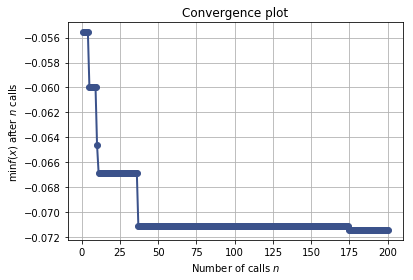

In [12]:
from skopt.plots import plot_convergence
_ = plot_convergence(gp_res);

#### Plot cumulative regret

In [ ]:
from skopt.plots import plot_regret
_ = plot_regret(gp_res)

#### Plot evaluation matrix

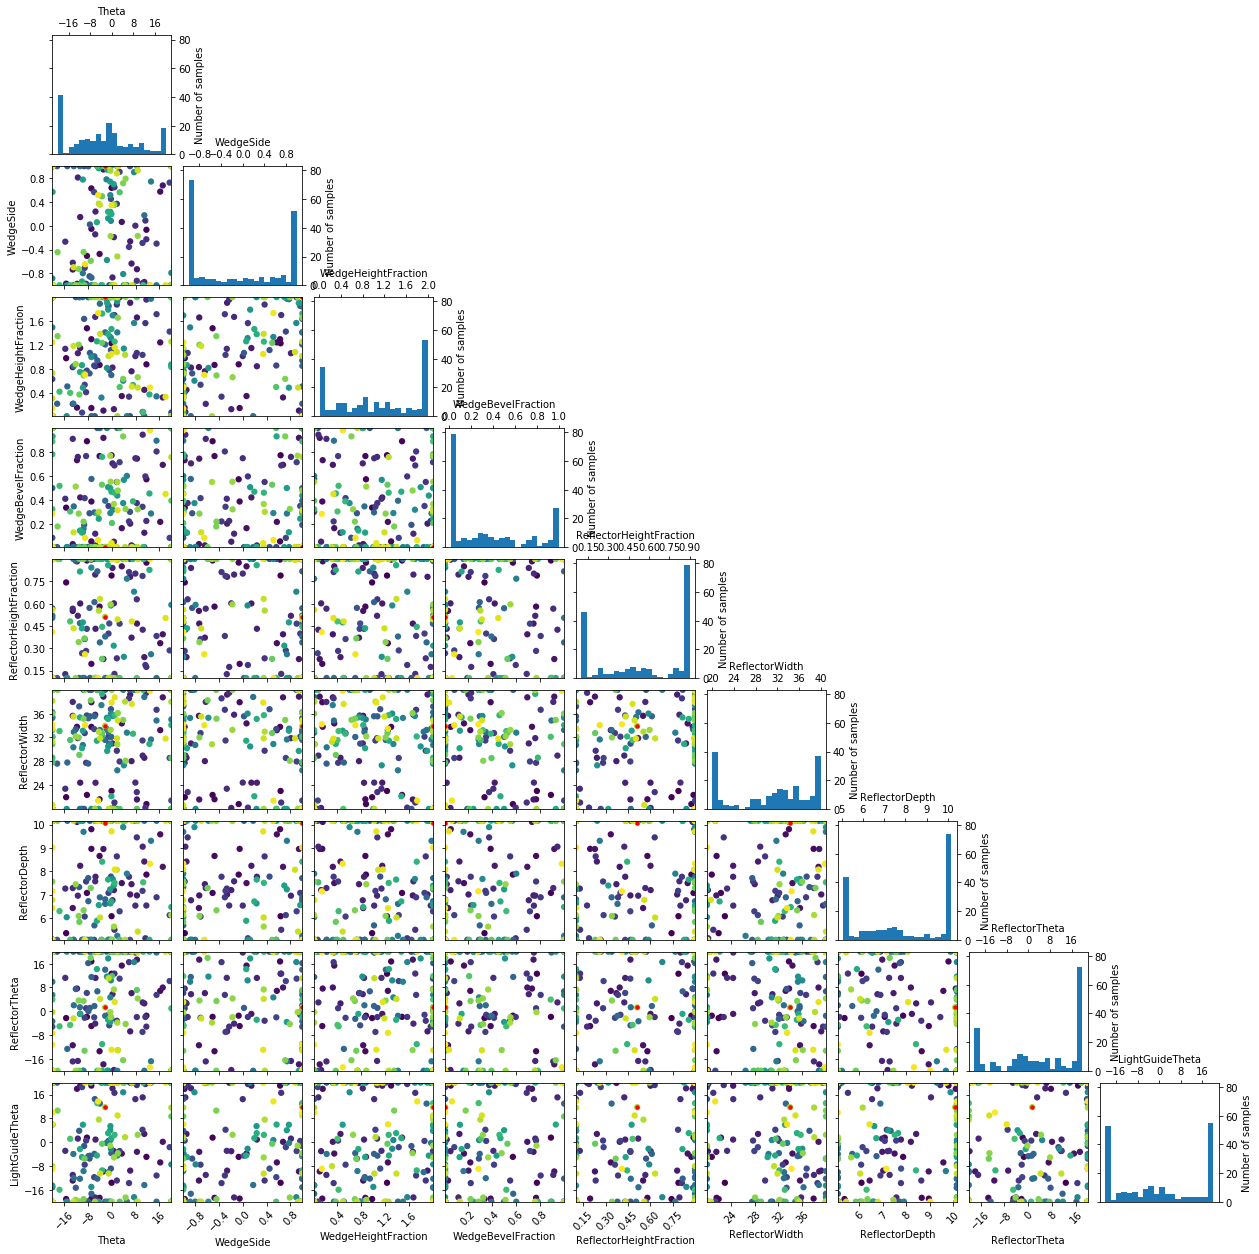

In [28]:
from skopt.plots import plot_evaluations
_ = plot_evaluations(gp_res, dimensions = parameter_names)

#### Plot objective matrix

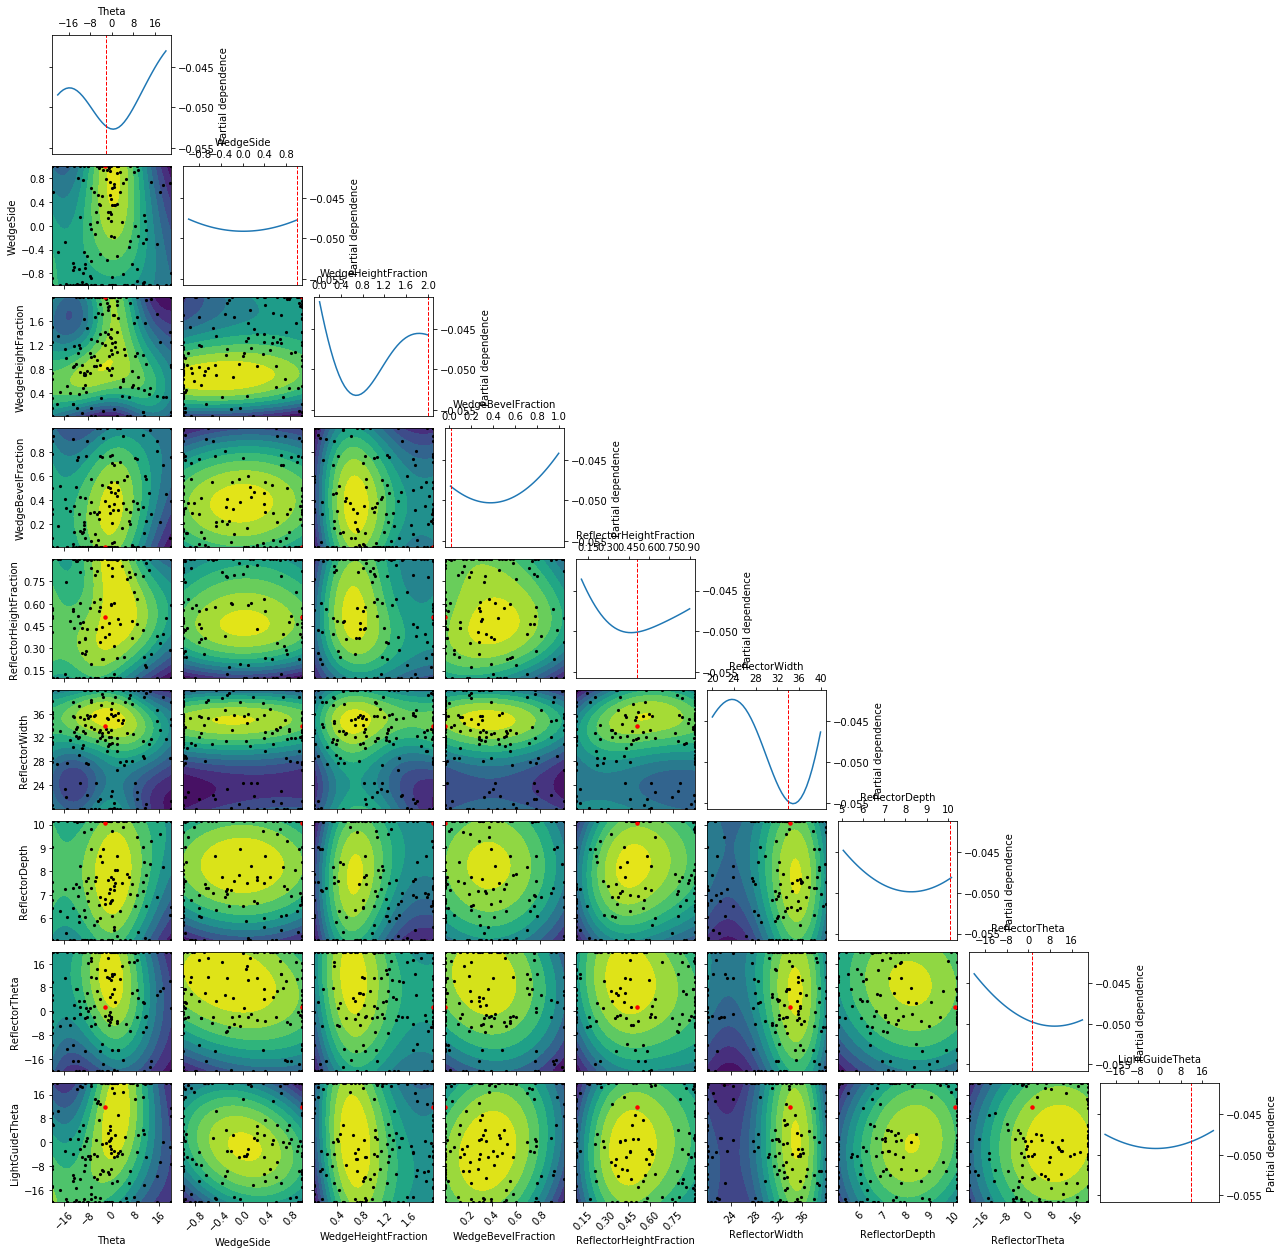

In [29]:
from skopt.plots import plot_objective
_ = plot_objective(gp_res, dimensions = parameter_names)

### Sequential optimization using gradient boosted trees

In [ ]:
from skopt import gbrt_minimize

gbrt_res = gbrt_minimize(
    objective_function,
    parameter_space,
    acq_func = "LCB", # EI, PI, LCB, PIps, EIps
    n_calls = 15,
    n_random_starts = 5,
    random_state = random_state,
    verbose = verbose)

#### Plot convergence

In [ ]:
from skopt.plots import plot_convergence
_ = plot_convergence(gbrt_res);

#### Plot evaluation matrix

In [ ]:
from skopt.plots import plot_evaluations
_ = plot_evaluations(gbrt_res)

#### Plot objective matrix

In [ ]:
from skopt.plots import plot_objective
_ = plot_objective(gbrt_res)

### Sequential optimisation using decision trees

In [ ]:
from skopt import forest_minimize

forest_res = forest_minimize(
    objective_function,
    parameter_space,
    n_calls = 10,
    base_estimator = "ET",
    random_state = random_state,
    verbose = verbose)

#### Plot convergence

In [ ]:
from skopt import plot_convergence
_ = plot_convergence(forest_res);

#### Plot evaluation matrix

In [ ]:
from skopt.plots import plot_evaluations
_ = plot_evaluations(forest_res)

#### Plot objective matrix

In [ ]:
from skopt.plots import plot_objective
_ = plot_objective(forest_res)